In [1]:
# Setup / imports

import warnings
from datetime import datetime, timedelta, date
from pathlib import Path
import sys

# --- make repo imports work from notebooks ---
# If you launch the notebook from inside `market_data/`, Python won't find the package.
PROJECT_ROOT = Path.cwd()
if not (PROJECT_ROOT / "market_data").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent
sys.path.insert(0, str(PROJECT_ROOT))
print("Working dir:", Path.cwd())
print("Project root:", PROJECT_ROOT)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Jupyter-friendly table display
try:
    from IPython.display import display
except Exception:
    display = print

# Optional (prettier heatmaps). If seaborn isn't installed, we'll fall back to matplotlib.
try:
    import seaborn as sns
    _HAS_SEABORN = True
except Exception:
    sns = None
    _HAS_SEABORN = False

from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")

RANDOM_STATE = 7
plt.rcParams["figure.figsize"] = (12, 6)


def _as_date(x) -> date:
    """Coerce YYYY-MM-DD / datetime / date -> date."""
    if isinstance(x, date) and not isinstance(x, datetime):
        return x
    if isinstance(x, datetime):
        return x.date()
    return datetime.strptime(str(x), "%Y-%m-%d").date()


def _previous_business_day(d: date) -> date:
    """Naive prev business day (Mon->Fri)."""
    while d.weekday() >= 5:  # Sat/Sun
        d -= timedelta(days=1)
    # If today is Mon, go to Fri
    if d.weekday() == 0:
        return d - timedelta(days=3)
    return d - timedelta(days=1)


Working dir: c:\Users\jdejo\Market_Data_Processing\market_data
Project root: c:\Users\jdejo\Market_Data_Processing


## Intraday agglomerative clustering (3-minute bars)

This notebook:
- Loads symbols from the **HADV** watchlist (`market_data/watchlists_locations.py`).
- Pulls intraday OHLCV via `intraday_import()` (`market_data/price_data_import.py`).
- Builds a per-symbol intraday “shape” vector using **3-minute log returns**.
- Runs **Agglomerative Clustering** (scikit-learn) using a correlation-based distance.
- Visualizes clusters with PCA + a correlation heatmap.


In [2]:
# Parameters + watchlist

from market_data.watchlists_locations import make_watchlist, hadv
import market_data.fundamentals as fu

# ---- user controls ----
TARGET_DAY = None  # set to "YYYY-MM-DD" to force a day; None -> previous business day
MAX_SYMBOLS = None   # keep this moderate; intraday API is heavier than daily

#The following line can vary.
specific_symbols = fu.sector_industry_member_search("Technology", level="sector")

N_CLUSTERS = 15

# Intraday settings
TIMESPAN = "minute"   # Polygon aggregates
MULTIPLIER = 1         # 1-minute bars
RESAMPLE = "3min"      # resample to 3-minute bars in the importer
MARKET_OPEN_ONLY = True

MIN_COVERAGE = 0.95    # min fraction of bars present to keep a symbol

# -----------------------

symbols = make_watchlist(hadv)
# basic cleanup
symbols = [s.strip().upper() for s in symbols if str(s).strip()]
# preserve order while de-duping
symbols = list(dict.fromkeys(symbols))

if MAX_SYMBOLS is not None:
    symbols = symbols[:MAX_SYMBOLS]
else:
    # if fundamentals returns a non-list (e.g., Series), coerce to list
    symbols = list([sym for sym in specific_symbols if sym in symbols])

if TARGET_DAY is None:
    # Default to the most recent calendar day that is not Sat/Sun
    # (override with TARGET_DAY if you want a specific session)
    day = date.today()
    while day.weekday() >= 5:
        day -= timedelta(days=1)
else:
    day = _as_date(TARGET_DAY)

print(f"Using day: {day}")
print(f"Symbols: {len(symbols)} (showing first 20): {symbols[:20]}")

# Lock the pull to a single session/day
from_date = day.strftime("%Y-%m-%d")
to_date = day.strftime("%Y-%m-%d")


Using day: 2026-01-23
Symbols: 437 (showing first 20): ['AAOI', 'AAPL', 'ACIW', 'ACLS', 'ACMR', 'ACN', 'ADBE', 'ADEA', 'ADI', 'ADSK', 'ADTN', 'AEHR', 'AFRM', 'AGYS', 'AI', 'AIOT', 'AIP', 'AKAM', 'ALAB', 'ALGM']


In [3]:
# Import intraday price data (and resample to 3-minute bars)

from market_data.price_data_import import intraday_import

price_dict = intraday_import(
    wl=symbols,
    from_date=from_date,
    to_date=to_date,
    timespan=TIMESPAN,
    multiplier=MULTIPLIER,
    resample=RESAMPLE,
    market_open_only=MARKET_OPEN_ONLY,
)

# keep only non-empty frames
price_dict = {sym: df for sym, df in price_dict.items() if isinstance(df, pd.DataFrame) and len(df) > 0}
print(f"Imported: {len(price_dict)} / {len(symbols)}")

# quick sanity check
_any = next(iter(price_dict.values())) if price_dict else None
if _any is not None:
    print(_any.head())
    print("\nIndex tz info:", getattr(_any.index, "tz", None))


Importing Price Data:  43%|████▎     | 188/437 [00:29<00:10, 24.17it/s]

INFA: 't'
IOTS: 't'


Importing Price Data:  53%|█████▎    | 233/437 [00:33<00:21,  9.42it/s]

MTTR: 't'


Importing Price Data:  68%|██████▊   | 299/437 [00:37<00:12, 11.39it/s]

PWSC: 't'


Importing Price Data:  82%|████████▏ | 360/437 [00:42<00:05, 14.23it/s]

SWCH: 't'


Importing Price Data:  84%|████████▍ | 367/437 [00:43<00:06, 10.62it/s]

PRFT: 't'


Importing Price Data:  87%|████████▋ | 379/437 [00:43<00:02, 19.46it/s]

RST: 't'


Importing Price Data:  96%|█████████▌| 418/437 [00:46<00:01, 10.87it/s]

ZUO: 't'


Importing Price Data:  98%|█████████▊| 428/437 [00:48<00:01,  8.53it/s]

SWIR: 't'


Importing Price Data: 100%|██████████| 437/437 [00:49<00:00,  8.83it/s]

Imported: 428 / 437
                     Volume       VWAP    Open   Close   High      Low
Timestamp                                                             
2026-01-23 09:30:00   32388  96.646033  96.530  96.610  96.99  96.2500
2026-01-23 09:33:00    7578  96.478167  96.405  96.480  96.61  96.3011
2026-01-23 09:36:00   20272  96.245400  96.360  96.075  96.44  96.0750
2026-01-23 09:39:00   15828  95.984633  96.130  95.820  96.23  95.7650
2026-01-23 09:42:00   11554  95.746567  95.820  95.445  95.97  95.4300

Index tz info: None


## Build the feature matrix

We represent each stock by its intraday **3-minute log-return vector** for the chosen day.

- Rows = symbols
- Columns = 3-minute bars (time-of-day)

Then we standardize features and cluster stocks by similarity of their intraday return patterns.


In [4]:
# Build aligned 3-minute return matrix

# 1) compute 3-minute log returns per symbol
ret_series = {}
for sym, df in price_dict.items():
    if "Close" not in df.columns or len(df) < 5:
        continue

    close = df["Close"].astype(float)
    r = np.log(close).diff()
    r.name = sym
    ret_series[sym] = r

returns = pd.concat(ret_series.values(), axis=1) if ret_series else pd.DataFrame()

print("Raw returns matrix:", returns.shape)

# 2) keep symbols with good coverage
if len(returns) == 0:
    raise ValueError("No intraday returns available. Check API key, date range, or symbol list.")

coverage = returns.notna().mean().sort_values(ascending=False)
keep = coverage[coverage >= MIN_COVERAGE].index.tolist()
returns = returns[keep]

# 3) fill remaining missing values (returns -> 0 is usually reasonable for sparse bars)
returns = returns.fillna(0.0)

print("After coverage filter:", returns.shape)

# 4) prepare X = (n_symbols x n_timepoints)
X = returns.T.values
symbols_kept = returns.columns.tolist()

scaler = StandardScaler(with_mean=True, with_std=True)
Xz = scaler.fit_transform(X)

print(f"Xz: {Xz.shape} (symbols x 3-min bars)")


Raw returns matrix: (130, 428)
After coverage filter: (130, 299)
Xz: (299, 130) (symbols x 3-min bars)


## Agglomerative clustering

We cluster using a **correlation-based distance** between standardized intraday return vectors:

- correlation: \(\rho\)
- distance: \(d = 1 - \rho\)

Then we run scikit-learn’s `AgglomerativeClustering` with average linkage.

In [5]:
# Fit agglomerative clustering using correlation distance

# correlation between rows (stocks)
corr = np.corrcoef(Xz)
dist = 1.0 - corr
# numerical cleanup
dist = np.nan_to_num(dist, nan=1.0, posinf=1.0, neginf=1.0)
np.fill_diagonal(dist, 0.0)

# sklearn changed `affinity` -> `metric` across versions; handle both.
try:
    model = AgglomerativeClustering(
        n_clusters=N_CLUSTERS,
        metric="precomputed",
        linkage="average",
    )
except TypeError:
    model = AgglomerativeClustering(
        n_clusters=N_CLUSTERS,
        affinity="precomputed",
        linkage="average",
    )

labels = model.fit_predict(dist)
cluster_labels = pd.Series(labels, index=symbols_kept, name="cluster").sort_values()

cluster_labels.value_counts().sort_index()


cluster
0      78
1       4
2     101
3       5
4      32
5      37
6       4
7       7
8       2
9       6
10      3
11      2
12      2
13     10
14      6
Name: count, dtype: int64

## Dendrogram (hierarchical tree)

A dendrogram shows the full hierarchical merge structure behind agglomerative clustering. We build it from the same correlation-based distance matrix.

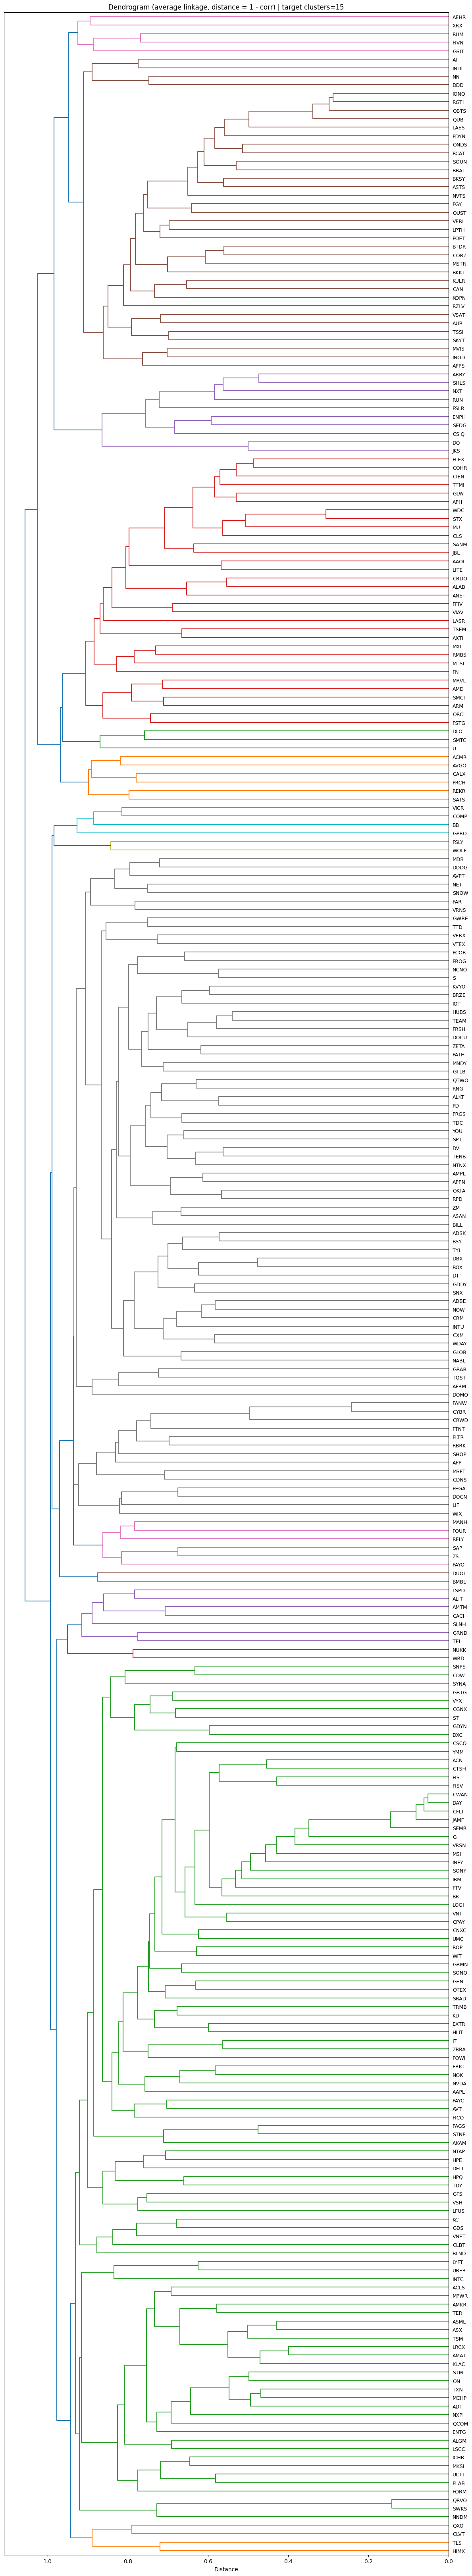

Tips:
- For readability: keep DENDRO_ORIENTATION='left' and increase DENDRO_FONT.
- For a cleaner summary: set TRUNCATE=True and adjust TRUNCATE_P.


In [6]:
# Dendrogram (more readable labels)

from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform

# ---- display controls ----
DENDRO_ORIENTATION = "left"   # "top" (labels on x), "left" (labels on y)
DENDRO_FONT = 9
TRUNCATE = False              # True -> show only last P merged leaves
TRUNCATE_P = 40
# -------------------------

# Build linkage from the same distance matrix used for AgglomerativeClustering
condensed = squareform(dist, checks=False)
Z = linkage(condensed, method="average")

# distance threshold that yields ~N_CLUSTERS clusters
# (the (N_CLUSTERS-1)th merge from the end)
if N_CLUSTERS > 1 and Z.shape[0] >= (N_CLUSTERS - 1):
    color_thr = Z[-(N_CLUSTERS - 1), 2]
else:
    color_thr = None

# Auto-scale figure size for readability
n = len(symbols_kept)
if DENDRO_ORIENTATION in ("left", "right"):
    fig_w, fig_h = 12, max(8, int(0.22 * n))
else:
    fig_w, fig_h = max(12, int(0.22 * n)), 7

plt.figure(figsize=(fig_w, fig_h))

_dkw = dict(
    Z=Z,
    labels=symbols_kept,
    orientation=DENDRO_ORIENTATION,
    leaf_rotation=0 if DENDRO_ORIENTATION in ("left", "right") else 90,
    leaf_font_size=DENDRO_FONT,
    color_threshold=color_thr,
)

# Only pass truncation arguments when enabled (SciPy can error if p=None)
if TRUNCATE:
    _dkw.update(dict(truncate_mode="lastp", p=int(TRUNCATE_P), show_contracted=True))

dendrogram(**_dkw)

plt.title(f"Dendrogram (average linkage, distance = 1 - corr) | target clusters={N_CLUSTERS}")
plt.xlabel("Distance" if DENDRO_ORIENTATION in ("left", "right") else None)
plt.ylabel("Distance" if DENDRO_ORIENTATION in ("top", "bottom") else None)
plt.tight_layout()
plt.show()

print("Tips:")
print("- For readability: keep DENDRO_ORIENTATION='left' and increase DENDRO_FONT.")
print("- For a cleaner summary: set TRUNCATE=True and adjust TRUNCATE_P.")


## Visualize the clusters

- **PCA scatter**: quick 2D view of separation.
- **Correlation heatmap (sorted)**: blocks along the diagonal usually indicate coherent clusters.

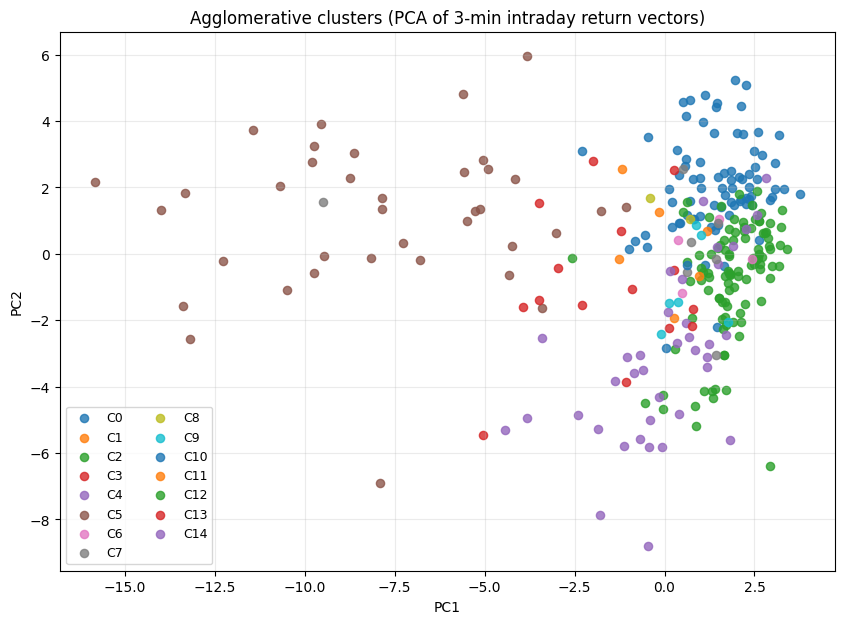

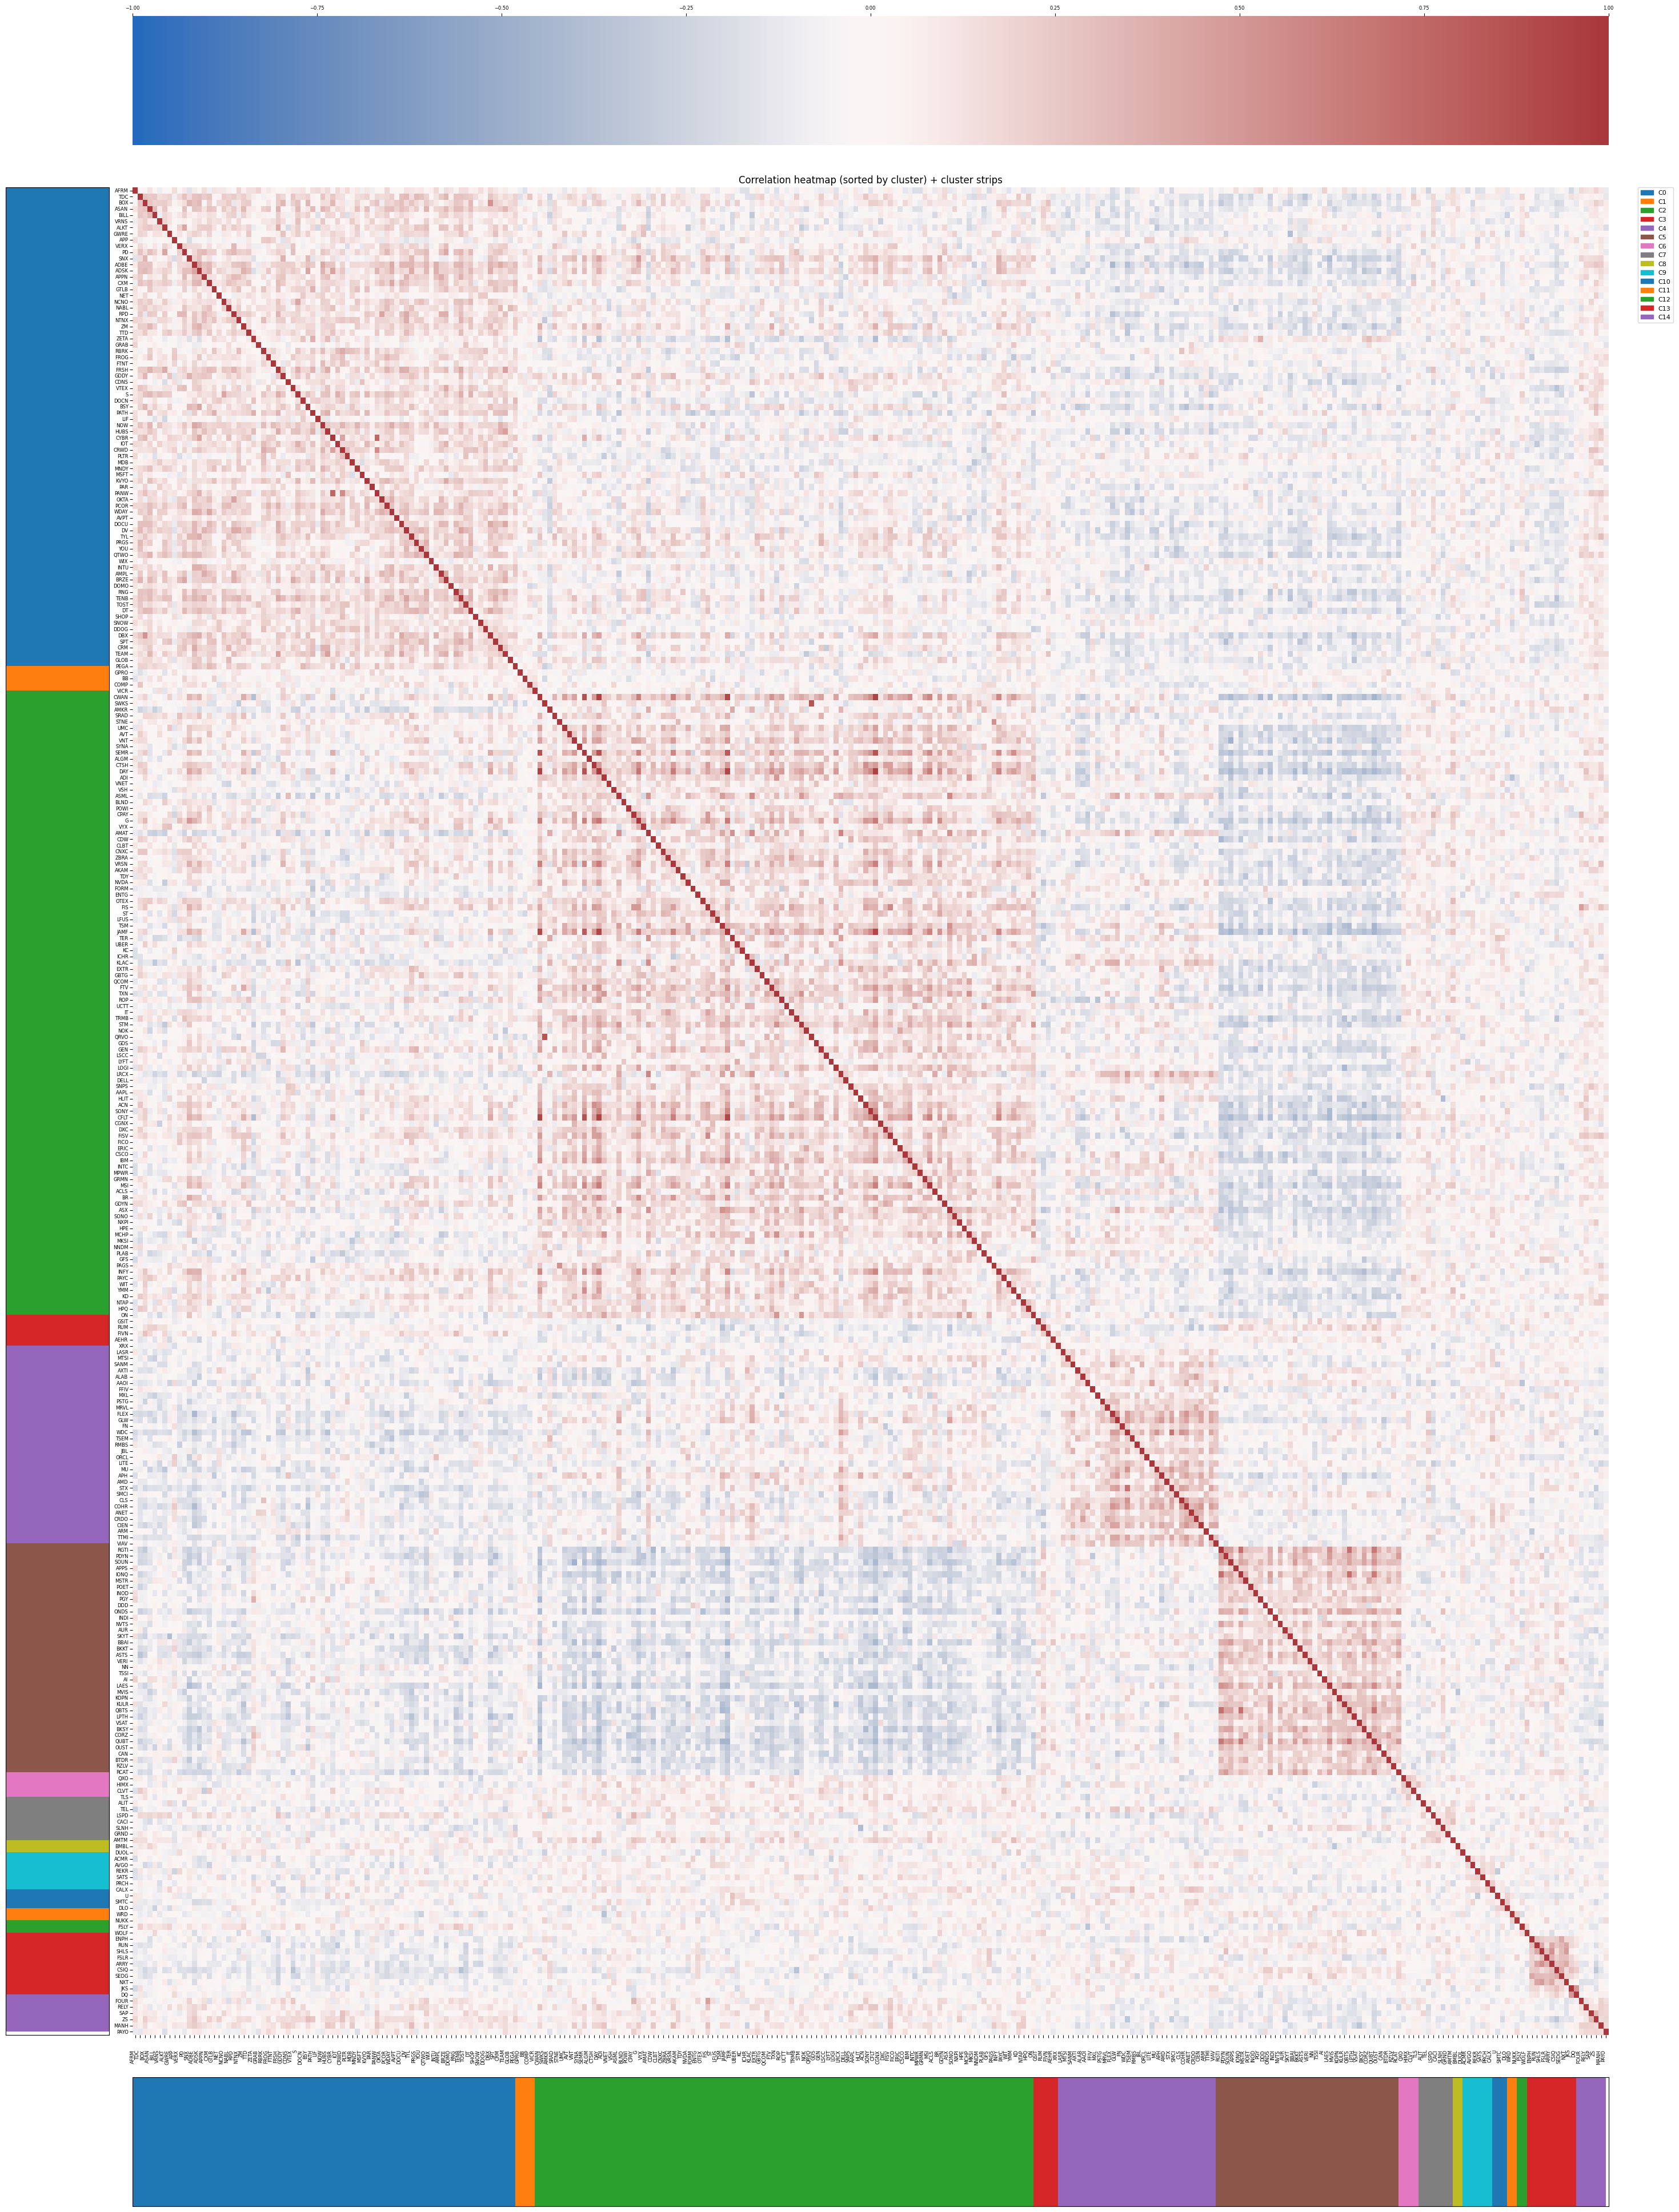

In [7]:
# PCA scatter

pca = PCA(n_components=2, random_state=RANDOM_STATE)
coords = pca.fit_transform(Xz)
coords_df = pd.DataFrame(coords, columns=["PC1", "PC2"], index=symbols_kept)
coords_df = coords_df.join(cluster_labels)

plt.figure(figsize=(10, 7))
for c in sorted(coords_df["cluster"].unique()):
    sub = coords_df[coords_df["cluster"] == c]
    plt.scatter(sub["PC1"], sub["PC2"], s=35, label=f"C{c}", alpha=0.8)
plt.title("Agglomerative clusters (PCA of 3-min intraday return vectors)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(ncol=2, fontsize=9)
plt.grid(alpha=0.25)
plt.show()


# Correlation heatmap (sorted by cluster) + cluster color strips
order = cluster_labels.sort_values().index
corr_df = pd.DataFrame(corr, index=symbols_kept, columns=symbols_kept).loc[order, order]
clusters_in_order = cluster_labels.loc[order].astype(int)

# ---- label/size controls ----
# If you still want all labels, set HEATMAP_SHOW_EVERY = 1.
# If you want automatic thinning, set HEATMAP_SHOW_EVERY = None.
HEATMAP_SHOW_EVERY = 1  # None -> auto; or set to 1/2/5/10...

# Let the notebook pick a readable font size based on n (override by setting an int)
HEATMAP_FONT = None

# X-axis labels
SHOW_X_LABELS = True
X_LABEL_ROTATION = 90

# Spacing/readability controls for x labels
X_LABEL_EVERY = 1      # show every Nth x label (increase to 2/5/10 for more spacing)
X_LABEL_PAD = 15        # padding between axis and labels
X_LABEL_HA = "right"   # alignment for rotated labels

# Tick-label styling
# (Cluster membership is already shown via the strips; keep tick labels plain/legible.)
COLOR_TICK_LABELS = False
TICK_LABEL_COLOR = "black"

SHOW_CLUSTER_LEGEND = True
# -----------------------------

import matplotlib.patches as mpatches

n = len(order)

# auto thinning for labels
if HEATMAP_SHOW_EVERY is None:
    if n <= 60:
        step = 1
    elif n <= 120:
        step = 2
    elif n <= 250:
        step = 5
    else:
        step = 10
else:
    step = int(HEATMAP_SHOW_EVERY)

# auto font sizing (override by setting HEATMAP_FONT to an int)
if HEATMAP_FONT is None:
    if n <= 80:
        font = 12
    elif n <= 150:
        font = 10
    elif n <= 260:
        font = 8
    else:
        font = 6
else:
    font = int(HEATMAP_FONT)

# x label spacing can also be increased by widening the figure
n_x = n if not SHOW_X_LABELS else max(1, n // max(1, int(X_LABEL_EVERY)))
fig_w = max(15, min(42, int(0.25 * n_x)))

# auto-scale height; more height makes y labels readable
fig_h = max(10, int(0.22 * n))

# Cluster -> color mapping (stable)
uniq_clusters = sorted(clusters_in_order.unique())
if _HAS_SEABORN:
    palette = sns.color_palette("tab10", n_colors=max(10, len(uniq_clusters)))
    cluster_to_color = {c: palette[i % len(palette)] for i, c in enumerate(uniq_clusters)}
else:
    cmap = plt.get_cmap("tab10")
    cluster_to_color = {c: cmap(i % 10) for i, c in enumerate(uniq_clusters)}

# Build color strips (make them multiple pixels thick so they remain visible when figures are scaled)
STRIP_THICKNESS = 12  # pixels
row_strip = np.array([cluster_to_color[c] for c in clusters_in_order]).reshape(n, 1, -1)
col_strip = np.array([cluster_to_color[c] for c in clusters_in_order]).reshape(1, n, -1)

# thicken strips
row_strip = np.repeat(row_strip, STRIP_THICKNESS, axis=1)   # (n, thickness, 3)
col_strip = np.repeat(col_strip, STRIP_THICKNESS, axis=0)   # (thickness, n, 3)

# Layout: top colorbar + heatmap + bottom strip (x-axis), plus left strip
fig = plt.figure(figsize=(fig_w, fig_h))
gs = fig.add_gridspec(
    nrows=3,
    ncols=2,
    # Make strips clearly visible
    width_ratios=[0.7, 10],
    height_ratios=[0.7, 10, 0.7],  # colorbar, heatmap, bottom strip
    wspace=0.03,
    hspace=0.06,
)

# left strip aligns to heatmap row
ax_row = fig.add_subplot(gs[1, 0])
# heatmap
ax = fig.add_subplot(gs[1, 1])
# bottom (x-axis) cluster strip
ax_col = fig.add_subplot(gs[2, 1])
# top colorbar axis
cax = fig.add_subplot(gs[0, 1])

ax_row.imshow(row_strip, aspect="auto", interpolation="nearest")
ax_col.imshow(col_strip, aspect="auto", interpolation="nearest")

# Hide ticks but keep the strip visible (set_axis_off() can make it easy to miss)
ax_col.set_xticks([])
ax_col.set_yticks([])
ax_row.set_xticks([])
ax_row.set_yticks([])
ax_col.set_frame_on(True)
ax_row.set_frame_on(True)

if _HAS_SEABORN:
    # show every Nth label to avoid overlap
    ylabels = [lbl if (i % step == 0) else "" for i, lbl in enumerate(order)]

    x_step = max(1, int(X_LABEL_EVERY))
    xlabels = [lbl if (i % x_step == 0) else "" for i, lbl in enumerate(order)] if SHOW_X_LABELS else False

    sns.heatmap(
        corr_df,
        ax=ax,
        cmap="vlag",
        center=0,
        vmin=-1,
        vmax=1,
        xticklabels=xlabels,
        yticklabels=ylabels,
        cbar_ax=cax,
        cbar_kws={"orientation": "horizontal"},
    )

    # colorbar formatting (top)
    cax.xaxis.set_ticks_position("top")
    cax.xaxis.set_label_position("top")
    cax.tick_params(axis="x", labelsize=font)
    cax.set_ylabel("")
    ax.tick_params(axis="y", labelsize=font, pad=2)
    if SHOW_X_LABELS:
        ax.tick_params(axis="x", labelsize=font, pad=X_LABEL_PAD)
        for tick in ax.get_xticklabels():
            tick.set_rotation(X_LABEL_ROTATION)
            tick.set_ha(X_LABEL_HA)

    # Force tick-label text to be plain black with no background/outline
    for tick in ax.get_yticklabels() + ax.get_xticklabels():
        tick.set_color(TICK_LABEL_COLOR)
        tick.set_path_effects([])
        tick.set_bbox(None)
else:
    im = ax.imshow(corr_df.values, cmap="coolwarm", vmin=-1, vmax=1, aspect="auto")
    cb = fig.colorbar(im, cax=cax, orientation="horizontal")
    cax.xaxis.set_ticks_position("top")
    cax.xaxis.set_label_position("top")
    cax.tick_params(axis="x", labelsize=font)

    yt = list(range(0, n, step))
    ax.set_yticks(yt)
    ax.set_yticklabels([order[i] for i in yt], fontsize=font)

    if SHOW_X_LABELS:
        x_step = max(1, int(X_LABEL_EVERY))
        xt = list(range(0, n, x_step))
        ax.set_xticks(xt)
        ax.set_xticklabels([order[i] for i in xt], fontsize=font, rotation=X_LABEL_ROTATION, ha=X_LABEL_HA)
    else:
        ax.set_xticks([])

    # Force tick-label text to be plain black with no background/outline
    for tick in ax.get_yticklabels() + ax.get_xticklabels():
        tick.set_color(TICK_LABEL_COLOR)
        tick.set_path_effects([])
        tick.set_bbox(None)

# Align the strips with the heatmap axes
ax_col.set_xlim(ax.get_xlim())
ax_row.set_ylim(ax.get_ylim())

# Make the colorbar axis clean
cax.set_yticks([])

ax.set_title("Correlation heatmap (sorted by cluster) + cluster strips")

# Optional legend for cluster colors
if SHOW_CLUSTER_LEGEND and len(uniq_clusters) <= 20:
    handles = [mpatches.Patch(color=cluster_to_color[c], label=f"C{c}") for c in uniq_clusters]
    ax.legend(handles=handles, bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0, fontsize=8)

# Manual layout (leave enough room for y tick labels + left strip)
right = 0.82 if (SHOW_CLUSTER_LEGEND and len(uniq_clusters) <= 20) else 0.92
# more bottom margin when x labels are shown (esp. rotation=90)
bottom = 0.34 if SHOW_X_LABELS else 0.08

# heuristically allocate space for y-labels
max_len = max((len(str(s)) for s in order), default=5)
left = min(0.42, 0.12 + 0.008 * max_len)

fig.subplots_adjust(left=left, right=right, top=0.93, bottom=bottom, wspace=0.03, hspace=0.03)
plt.show()


In [8]:
# Inspect cluster membership

clusters = (
    cluster_labels
    .reset_index()
    .rename(columns={"index": "symbol"})
    .sort_values(["cluster", "symbol"])
)

display(clusters)

print("\nMembers by cluster:\n")
for c, grp in clusters.groupby("cluster"):
    syms = grp["symbol"].tolist()
    print(f"Cluster {c} (n={len(syms)}):")
    print(", ".join(syms))
    print()


,symbol,cluster
28,ADBE,0
29,ADSK,0
0,AFRM,0
6,ALKT,0
16,AMPL,0
...,...,...
297,MANH,14
295,PAYO,14
293,RELY,14
296,SAP,14



Members by cluster:

Cluster 0 (n=78):
ADBE, ADSK, AFRM, ALKT, AMPL, APP, APPN, ASAN, AVPT, BILL, BOX, BRZE, BSY, CDNS, CRM, CRWD, CXM, CYBR, DBX, DDOG, DOCN, DOCU, DOMO, DT, DV, FROG, FRSH, FTNT, GDDY, GLOB, GRAB, GTLB, GWRE, HUBS, INTU, IOT, KVYO, LIF, MDB, MNDY, MSFT, NABL, NCNO, NET, NOW, NTNX, OKTA, PANW, PAR, PATH, PCOR, PD, PEGA, PLTR, PRGS, QTWO, RBRK, RNG, RPD, S, SHOP, SNOW, SNX, SPT, TDC, TEAM, TENB, TOST, TTD, TYL, VERX, VRNS, VTEX, WDAY, WIX, YOU, ZETA, ZM

Cluster 1 (n=4):
BB, COMP, GPRO, VICR

Cluster 2 (n=101):
AAPL, ACLS, ACN, ADI, AKAM, ALGM, AMAT, AMKR, ASML, ASX, AVT, BLND, BR, CDW, CFLT, CGNX, CLBT, CNXC, CPAY, CSCO, CTSH, CWAN, DAY, DELL, DXC, ENTG, ERIC, EXTR, FICO, FIS, FISV, FORM, FTV, G, GBTG, GDS, GDYN, GEN, GFS, GRMN, HLIT, HPE, HPQ, IBM, ICHR, INFY, INTC, IT, JAMF, KC, KD, KLAC, LFUS, LOGI, LRCX, LSCC, LYFT, MCHP, MKSI, MPWR, MSI, NNDM, NOK, NTAP, NVDA, NXPI, ON, OTEX, PAGS, PAYC, PLAB, POWI, QCOM, QRVO, ROP, SEMR, SNPS, SONO, SONY, SRAD, ST, STM, STNE, SW